In [30]:
from pyod.utils.data import generate_data_clusters
from pyod.utils.utility import standardizer
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from pyod.models.combination import average, maximization

import numpy as np

import matplotlib.pyplot as plt

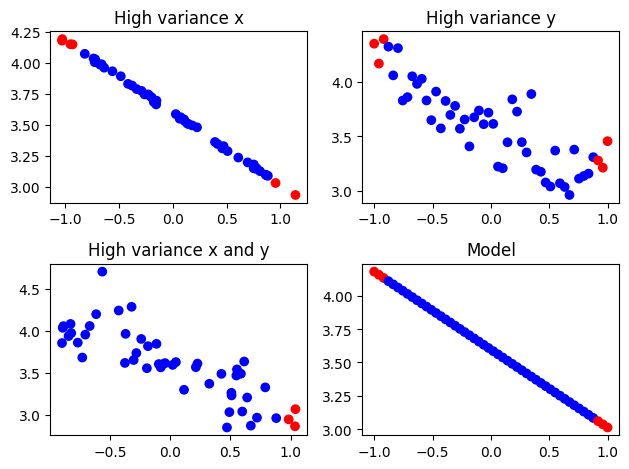

In [34]:
NO_POINTS = 50

domain: np.array = np.linspace(-1, 1, NO_POINTS)
domain = np.vstack((domain, np.ones(NO_POINTS))).T
a: np.array = np.random.uniform(-1, 1, 1)
b: np.array = np.random.uniform(-5, 5, 1)
c: np.array = np.random.uniform(-5, 5, 1)

μ: np.array = np.random.uniform(-1, 1, 1)
σ: np.array = np.random.uniform(0, 1, 1)
ε: np.array = np.random.normal(μ, σ ** 2, 1)

f_x =  lambda x, a, b, ε, c = 0: a * x[:, 0] + b * x[:, 1] + ε + c

model: np.array = f_x(domain, a, b, ε)

# high variance x
x_var_on_x: np.array = domain[:, 0] + np.random.normal(0, .2, NO_POINTS)

# high variance y
y_var_on_y: np.array = model + np.random.normal(0, .2, NO_POINTS)

# high variance x and y
x_var_on_both: np.array = domain[:, 0] + np.random.normal(0, .2, NO_POINTS)
y_var_on_both: np.array = model + np.random.normal(0, .2, NO_POINTS)


# stack all points
# x_var_point = np.vstack((x_var_on_x, f_x(x_var_on_x, a, b, ε) + np.random.normal(0, 0.01, NO_POINTS))).T
# y_var_point = np.vstack((domain, y_var_on_y)).T
# both_var_point = np.vstack((x_var_on_both, y_var_on_both)).T
# model_point = np.vstack((domain, model)).T

x_var_point = np.vstack((x_var_on_x, np.ones(NO_POINTS))).T
y_var_point = np.vstack((domain[:, 0], np.ones(NO_POINTS))).T
both_var_point = np.vstack((x_var_on_both, np.ones(NO_POINTS))).T
model_point = np.vstack((domain[:, 0], np.ones(NO_POINTS))).T

#combine all points
X = np.vstack((x_var_point, y_var_point, both_var_point, model_point))

U, Σ, V = np.linalg.svd(X, full_matrices=False)

H = U @ U.T

# take diagonal of H
leverage_scores = np.diag(H)
threshold = np.quantile(leverage_scores, 0.90)

# make 4 subplots
fig, axs = plt.subplots(2, 2)

# plot high variance x
axs[0, 0].scatter(x_var_on_x, f_x(x_var_point, a, b, ε) + np.random.normal(0, 0.01, NO_POINTS), color=np.where(leverage_scores[:NO_POINTS] < threshold, 'blue', 'red'))
axs[0, 0].set_title('High variance x')

# plot high variance y
axs[0, 1].scatter(domain[:, 0], y_var_on_y, color=np.where(leverage_scores[NO_POINTS:2*NO_POINTS] < threshold, 'blue', 'red'))
axs[0, 1].set_title('High variance y')

# plot high variance x and y
axs[1, 0].scatter(x_var_on_both, y_var_on_both, color=np.where(leverage_scores[2*NO_POINTS:3*NO_POINTS] < threshold, 'blue', 'red'))
axs[1, 0].set_title('High variance x and y')

# plot model
axs[1, 1].scatter(domain[:, 0], model, color=np.where(leverage_scores[3*NO_POINTS:] < threshold, 'blue', 'red'))
axs[1, 1].set_title('Model')

plt.tight_layout()
plt.show()


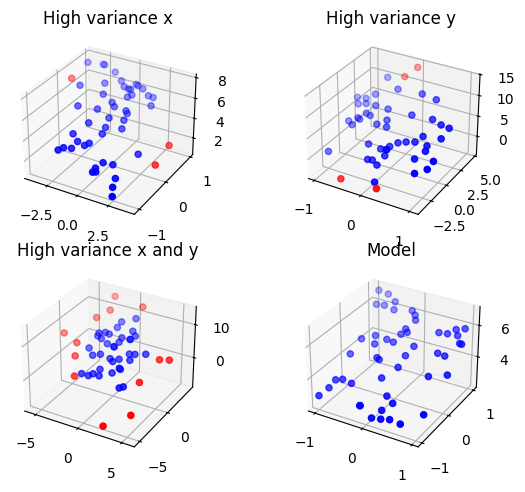

In [37]:
# data points should be 2d now

domain_2d: np.array = np.random.uniform(-1, 1, (NO_POINTS, 2))
model_2d: np.array = f_x(domain_2d, a, b, ε, c)

# high variance x
x_var_on_x_2d: np.array = domain_2d[:, 0] + np.random.normal(0, 2, NO_POINTS)
y_var_on_x_2d: np.array = domain_2d[:, 1] + np.random.normal(0, .05, NO_POINTS)

X_var_2d = np.vstack((x_var_on_x_2d, y_var_on_x_2d)).T

# high variance y
x_var_on_y_2d: np.array = domain_2d[:, 0] + np.random.normal(0, .05, NO_POINTS)
y_var_on_y_2d: np.array = domain_2d[:, 1] + np.random.normal(0, 2, NO_POINTS)

Y_var_2d = np.vstack((x_var_on_y_2d, y_var_on_y_2d)).T

# high variance x and y
x_var_on_both_2d: np.array = domain_2d[:, 0] + np.random.normal(0, 2, NO_POINTS)
y_var_on_both_2d: np.array = domain_2d[:, 1] + np.random.normal(0, 2, NO_POINTS)

XY_var_2d = np.vstack((x_var_on_both_2d, y_var_on_both_2d)).T


X = np.vstack((X_var_2d, Y_var_2d, XY_var_2d, domain_2d))

U, Σ, V = np.linalg.svd(X, full_matrices=False)

H = U @ U.T

# take diagonal of H
leverage_scores = np.diag(H)

threshold = np.quantile(leverage_scores, 0.90)

# make 4 subplots in 3d

fig = plt.figure()

# plot high variance x
ax = fig.add_subplot(221, projection='3d')
ax.scatter(x_var_on_x_2d, y_var_on_x_2d, f_x(X_var_2d, a, b, ε, c), color=np.where(leverage_scores[:NO_POINTS] < threshold, 'blue', 'red'))
ax.set_title('High variance x')

# plot high variance y
ax = fig.add_subplot(222, projection='3d')
ax.scatter(x_var_on_y_2d, y_var_on_y_2d, f_x(Y_var_2d, a, b, ε, c), color=np.where(leverage_scores[NO_POINTS:2*NO_POINTS] < threshold, 'blue', 'red'))
ax.set_title('High variance y')

# plot high variance x and y
ax = fig.add_subplot(223, projection='3d')
ax.scatter(x_var_on_both_2d, y_var_on_both_2d, f_x(XY_var_2d, a, b, ε, c), color=np.where(leverage_scores[2*NO_POINTS:3*NO_POINTS] < threshold, 'blue', 'red'))
ax.set_title('High variance x and y')

# plot model
ax = fig.add_subplot(224, projection='3d')
ax.scatter(domain_2d[:, 0], domain_2d[:, 1], model_2d, color=np.where(leverage_scores[3*NO_POINTS:] < threshold, 'blue', 'red'))
ax.set_title('Model')

plt.tight_layout()
plt.show()

# 2

/Users/radubuzas/Documents/Facultate/Master-SAL/AnomalyDetection/lab/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/Users/radubuzas/Documents/Facultate/Master-SAL/AnomalyDetection/lab/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/Users/radubuzas/Documents/Facultate/Master-SAL/AnomalyDetection/lab/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/Users/radubuzas/Documents/Facultate/Master-SAL/AnomalyDetection/lab/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


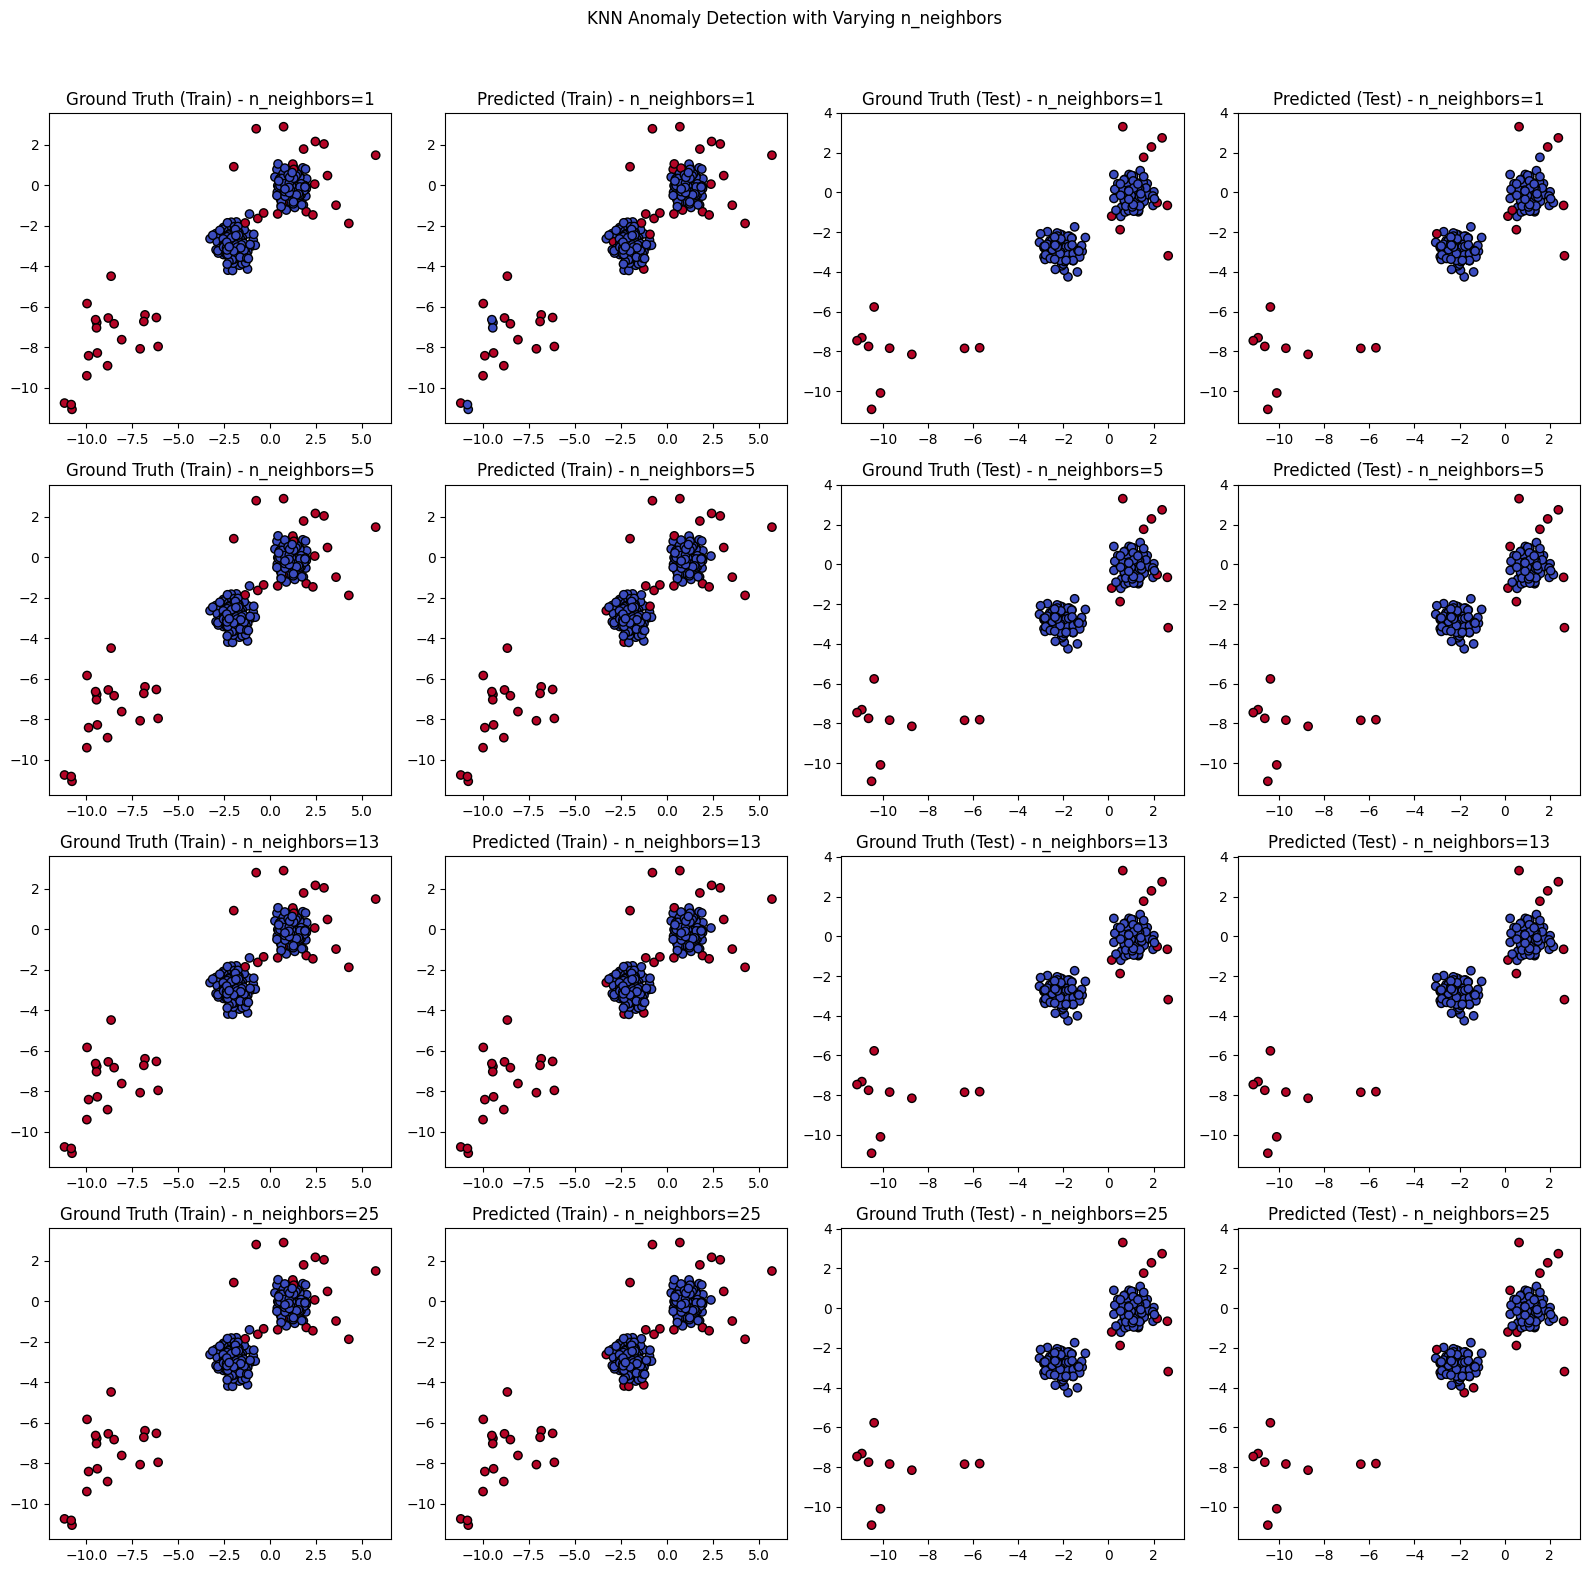

Balanced Accuracy for n_neighbors=1: 0.9418
Balanced Accuracy for n_neighbors=5: 0.9709
Balanced Accuracy for n_neighbors=13: 0.9737
Balanced Accuracy for n_neighbors=25: 0.9599


In [75]:
from pyod.models.knn import KNN
from sklearn.metrics import balanced_accuracy_score
X_train, X_test, y_train, y_test = generate_data_clusters(n_train=400, n_test=200, n_clusters=2, n_features=2, contamination=0.1, size='same')  # I've spent some time on this line
# the documentation specifies different A DIFFERENT RETURN ORDER :)
# https://pyod.readthedocs.io/en/latest/pyod.utils.html#id7
knn = KNN(contamination=0.1, n_neighbors=5)

n_neighbors_values = [1, 5, 13, 25]
balanced_accuracies = []


fig, axes = plt.subplots(4, 4, figsize=(16, 16))
fig.suptitle("KNN Anomaly Detection with Varying n_neighbors")

for i, n_neighbors in enumerate(n_neighbors_values):
    # Initialize and train the KNN model for each n_neighbors value
    knn = KNN(n_neighbors=n_neighbors, contamination=0.1)
    y_train_pred = knn.fit_predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate balanced accuracy
    balanced_accuracy = balanced_accuracy_score(y_test, y_test_pred)
    balanced_accuracies.append(balanced_accuracy)

    # Ground Truth (Train)
    axes[i, 0].scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='coolwarm', marker='o', edgecolor='k')
    axes[i, 0].set_title(f"Ground Truth (Train) - n_neighbors={n_neighbors}")

    # Predicted Labels (Train)
    axes[i, 1].scatter(X_train[:, 0], X_train[:, 1], c=y_train_pred, cmap='coolwarm', marker='o', edgecolor='k')
    axes[i, 1].set_title(f"Predicted (Train) - n_neighbors={n_neighbors}")

    # Ground Truth (Test)
    axes[i, 2].scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap='coolwarm', marker='o', edgecolor='k')
    axes[i, 2].set_title(f"Ground Truth (Test) - n_neighbors={n_neighbors}")

    # Predicted Labels (Test)
    axes[i, 3].scatter(X_test[:, 0], X_test[:, 1], c=y_test_pred, cmap='coolwarm', marker='o', edgecolor='k')
    axes[i, 3].set_title(f"Predicted (Test) - n_neighbors={n_neighbors}")

# Adjust layout and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Print balanced accuracies for each n_neighbors value
for n_neighbors, accuracy in zip(n_neighbors_values, balanced_accuracies):
    print(f"Balanced Accuracy for n_neighbors={n_neighbors}: {accuracy:.4f}")

# 3

/Users/radubuzas/Documents/Facultate/Master-SAL/AnomalyDetection/lab/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)
/Users/radubuzas/Documents/Facultate/Master-SAL/AnomalyDetection/lab/.venv/lib/python3.12/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


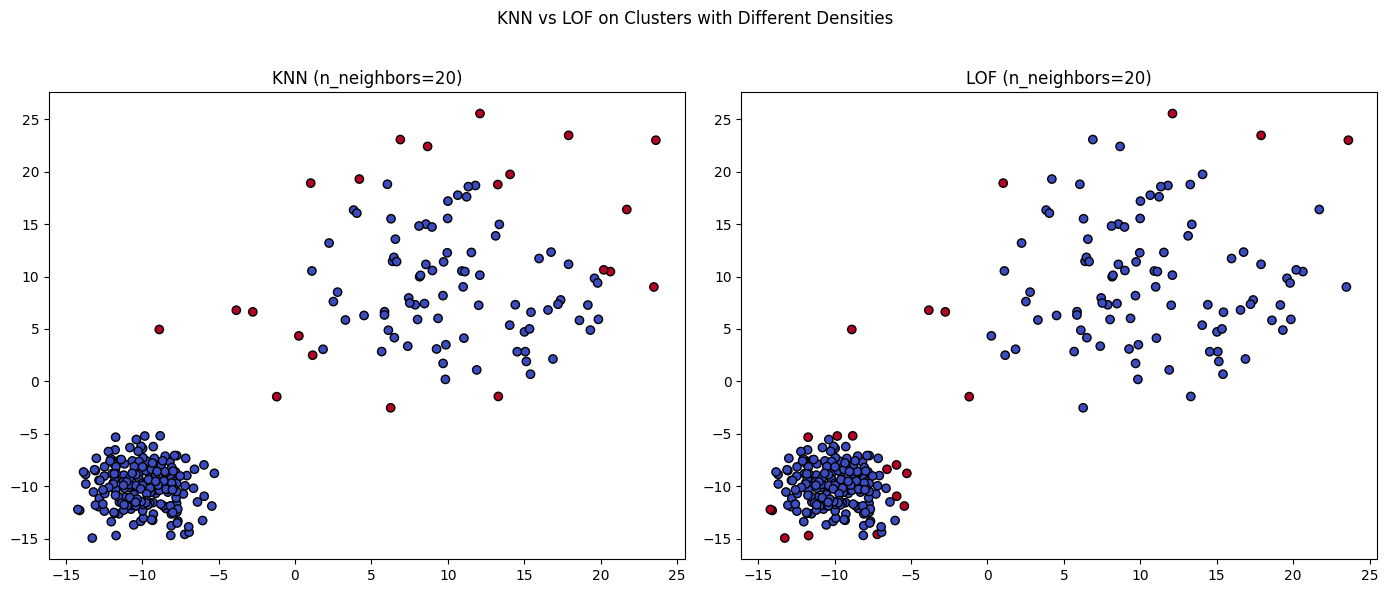

In [81]:
from pyod.models.lof import LOF

cluster_1, _ = make_blobs(n_samples=200, n_features=2, centers=1, cluster_std=2, center_box=(-10, -10))
cluster_2, _ = make_blobs(n_samples=100, n_features=2, centers=1, cluster_std=6, center_box=(10, 10))

X = np.vstack((cluster_1, cluster_2))

knn = KNN(contamination=0.07, n_neighbors=20)
lof = LOF(contamination=0.07, n_neighbors=20)

y_knn_pred = knn.fit_predict(X)
y_lof_pred = lof.fit_predict(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle("KNN vs LOF on Clusters with Different Densities")

# Plot KNN results
ax1.scatter(X[:, 0], X[:, 1], c=y_knn_pred, cmap='coolwarm', marker='o', edgecolor='k')
ax1.set_title("KNN (n_neighbors=20)")

# Plot LOF results
ax2.scatter(X[:, 0], X[:, 1], c=y_lof_pred, cmap='coolwarm', marker='o', edgecolor='k')
ax2.set_title("LOF (n_neighbors=20)")

# Display plots
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 4

In [82]:
!curl "https://www.dropbox.com/s/galg3ihvxklf0qi/cardio.mat?dl=0" -L -o "cardio.mat"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   121  100   121    0     0    277      0 --:--:-- --:--:-- --:--:--   277
100    17  100    17    0     0     11      0  0:00:01  0:00:01 --:--:--   369
100   470    0   470    0     0    224      0 --:--:--  0:00:02 --:--:--   224
100 68318  100 68318    0     0  26085      0  0:00:02  0:00:02 --:--:--  551k


In [95]:
loaded_data = loadmat('cardio.mat')
X = loaded_data['X']
y = loaded_data['y'].ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

X_train_norm, X_test_norm = standardizer(X_train, X_test)

n_neighbors_range = np.random.randint(30, 121, 10)
train_scores = []
test_scores = []

for n_neighbors in n_neighbors_range:
    knn = KNN(n_neighbors=n_neighbors)
    knn.fit(X_train_norm)
    
    # Compute scores
    train_scores.append(knn.decision_function(X_train_norm))
    test_scores.append(knn.decision_function(X_test_norm))
    
    # Calculate and print balanced accuracy
    y_train_pred = knn.predict(X_train_norm)
    y_test_pred = knn.predict(X_test_norm)
    print(f"Balanced Accuracy for n_neighbors={n_neighbors} (train):", balanced_accuracy_score(y_train, y_train_pred))
    print(f"Balanced Accuracy for n_neighbors={n_neighbors} (test):", balanced_accuracy_score(y_test, y_test_pred))

Balanced Accuracy for n_neighbors=50 (train): 0.7235351109987784
Balanced Accuracy for n_neighbors=50 (test): 0.7801336319805626
Balanced Accuracy for n_neighbors=84 (train): 0.7513795863347235
Balanced Accuracy for n_neighbors=84 (test): 0.7811396681978664
Balanced Accuracy for n_neighbors=101 (train): 0.7599414465647247
Balanced Accuracy for n_neighbors=101 (test): 0.8010136289434722
Balanced Accuracy for n_neighbors=105 (train): 0.7640064872151313
Balanced Accuracy for n_neighbors=105 (test): 0.8010136289434722
Balanced Accuracy for n_neighbors=39 (train): 0.7199018492775601
Balanced Accuracy for n_neighbors=39 (test): 0.760259671234957
Balanced Accuracy for n_neighbors=48 (train): 0.7239668899279665
Balanced Accuracy for n_neighbors=48 (test): 0.7706996697164117
Balanced Accuracy for n_neighbors=114 (train): 0.7640064872151313
Balanced Accuracy for n_neighbors=114 (test): 0.8020196651607759
Balanced Accuracy for n_neighbors=103 (train): 0.7640064872151313
Balanced Accuracy for n_ne

In [102]:
train_scores_norm, test_scores_norm = standardizer(np.array(train_scores).T, np.array(test_scores).T)

average_train = average(train_scores_norm)
average_test = average(test_scores_norm)
max_train = maximization(train_scores_norm)
max_test = maximization(test_scores_norm)

In [116]:
y_train_pred_avg = np.where(average_train > np.quantile(average_train, 1 - 0.07), 1, 0)
y_test_pred_avg = np.where(average_test > np.quantile(average_test, 1 - 0.07), 1, 0)
y_train_pred_max = np.where(max_train > np.quantile(max_train, 1 - 0.07), 1, 0)
y_test_pred_max = np.where(max_test > np.quantile(max_test, 1 - 0.07), 1, 0)

print("Balanced Accuracy for Average Strategy (train):", balanced_accuracy_score(y_train, y_train_pred_avg))
print("Balanced Accuracy for Average Strategy (test):", balanced_accuracy_score(y_test, y_test_pred_avg))
print("Balanced Accuracy for Maximization Strategy (train):", balanced_accuracy_score(y_train, y_train_pred_max))
print("Balanced Accuracy for Maximization Strategy (test):", balanced_accuracy_score(y_test, y_test_pred_max))

Balanced Accuracy for Average Strategy (train): 0.6904776949323898
Balanced Accuracy for Average Strategy (test): 0.6695645571542462
Balanced Accuracy for Maximization Strategy (train): 0.6994713340915792
Balanced Accuracy for Maximization Strategy (test): 0.7008845525986105
